<a href="https://colab.research.google.com/github/Chen-Terese/CNN-SOM-thesis/blob/main/Thesis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Jan 28 10:24:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 48.4 MB/s eta 0:00:00


In [ ]:
from google.colab import files,drive
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"teresechen","key":"2a13c0dc9b2166dd30da6a704623ead2"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d imagesoasis/

Streaming output truncated to the last 5000 lines.
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: imagesoasis/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keras_cv
from keras_cv.models import ResNet18Backbone
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
import keras_hub

In [ ]:
# ────────────────────────────────────────────────
# Mount Google Drive for safe checkpointing
# ────────────────────────────────────────────────
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
# ────────────────────────────────────────────────
# Hyperparameters
# ────────────────────────────────────────────────
IMG_SIZE    = 64
BATCH_SIZE  = 32
EPOCHS      = 40
TEMPERATURE = 0.1
LR          = 4e-3
DATA_PATH = "/content/imagesoasis"

In [ ]:
# ────────────────────────────────────────────────
# Load as RGB (repeats grayscale → 3 channels automatically)
# ────────────────────────────────────────────────
dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    labels=None,                  # SimCLR = self-supervised → no labels needed
    color_mode='grayscale',
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Converts grayscale images to 3 channels for ResNet compatibility
dataset = dataset.map(
    lambda x: tf.image.grayscale_to_rgb(x),
    num_parallel_calls=tf.data.AUTOTUNE
)

Found 86437 files.


In [ ]:
# ────────────────────────────────────────────────
# SimCLR-style augmentations
# ────────────────────────────────────────────────
simclr_augmentation = keras.Sequential([
    layers.Rescaling(1./255),          # Normalize to [0,1]
    layers.RandomFlip("horizontal"),  # Simple flip augmentation
], name="simclr_aug")


def prepare_simclr_dataset(ds):
    def _pair(images):
        v1 = simclr_augmentation(images, training=True)
        v2 = simclr_augmentation(images, training=True)
        return v1, v2

    return ds.map(_pair, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train_ds = prepare_simclr_dataset(dataset)

In [ ]:
# ────────────────────────────────────────────────
# Model: Pretrained ResNet18
# ────────────────────────────────────────────────

base = keras_hub.models.ResNetBackbone.from_preset(
    "hf://keras/resnet_18_imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

x = base.output
x = layers.GlobalAveragePooling2D()(x)
encoder = keras.Model(base.input, x, name="MRI_Encoder")

for layer in base.layers[:100]:
    layer.trainable = False

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/836 [00:00<?, ?B/s]

model.weights.h5:   0%|          | 0.00/44.9M [00:00<?, ?B/s]

In [ ]:
# ────────────────────────────────────────────────
# Projection Head
# ────────────────────────────────────────────────
proj_head = keras.Sequential([
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128)
])

In [ ]:
# ────────────────────────────────────────────────
# Full SimCLR model
# ────────────────────────────────────────────────
inputs = keras.Input((IMG_SIZE, IMG_SIZE,  1))
feats = encoder(inputs)
projs = proj_head(feats)
simclr_model = Model(inputs, projs)

**LOSS**

In [ ]:
# ────────────────────────────────────────────────
# NT-Xent loss (standard SimCLR)
# ────────────────────────────────────────────────
def nt_xent_loss(z_i, z_j, temp=TEMPERATURE):
    z_i = tf.math.l2_normalize(z_i, axis=1)
    z_j = tf.math.l2_normalize(z_j, axis=1)
    z_all = tf.concat([z_i, z_j], axis=0)

    sim_matrix = tf.matmul(z_all, z_all, transpose_b=True) / temp

    batch_sz = tf.shape(z_i)[0]
    labels = tf.range(batch_sz)
    labels = tf.concat([labels + batch_sz, labels], axis=0)

    loss = tf.keras.losses.sparse_categorical_crossentropy(
        labels, sim_matrix, from_logits=True)
    return tf.reduce_mean(loss)

optimizer = AdamW(LR)

**Training Loop**

In [ ]:
@tf.function
def train_step(view1, view2):
    with tf.GradientTape() as tape:
        z1 = simclr_model(view1, training=True)
        z2 = simclr_model(view2, training=True)
        loss = nt_xent_loss(z1, z2)

    grads = tape.gradient(loss, simclr_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, simclr_model.trainable_variables))
    return loss

In [ ]:
# ────────────────────────────────────────────────
# Training loop with LR drop + Drive checkpointing
# ────────────────────────────────────────────────
print("Starting SimCLR pre-training on Alzheimer MRI dataset...")

for epoch in range(EPOCHS):

    # LR drop after warmup
    if epoch == 15:
        print("Reducing learning rate to 1e-3")
        optimizer.learning_rate.assign(1e-3)

    total_loss = 0.0
    num_batches = 0

    for view1, view2 in train_ds:
        loss = train_step(view1, view2)
        total_loss += float(loss)
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1:3d}/{EPOCHS} | avg loss: {avg_loss:.4f}")

print("Pre-training finished. Encoder is ready for downstream tasks.")

Starting SimCLR pre-training on Alzheimer MRI dataset...
Epoch   1/40 | avg loss: 1.2248
Epoch   2/40 | avg loss: 1.1586
Epoch   3/40 | avg loss: 1.1337
Epoch   4/40 | avg loss: 1.1238
Epoch   5/40 | avg loss: 1.1136
Epoch   6/40 | avg loss: 1.1067
Epoch   7/40 | avg loss: 1.1025
Epoch   8/40 | avg loss: 1.0990
Epoch   9/40 | avg loss: 1.0934
Epoch  10/40 | avg loss: 1.0934
Epoch  11/40 | avg loss: 1.0855
Epoch  12/40 | avg loss: 1.0887
Epoch  13/40 | avg loss: 1.0870
Epoch  14/40 | avg loss: 1.0859
Epoch  15/40 | avg loss: 1.0849
Reducing learning rate to 1e-3
Epoch  16/40 | avg loss: 1.0683
Epoch  17/40 | avg loss: 1.0639
Epoch  18/40 | avg loss: 1.0618
Epoch  19/40 | avg loss: 1.0584
Epoch  20/40 | avg loss: 1.0599
Epoch  21/40 | avg loss: 1.0547
Epoch  22/40 | avg loss: 1.0542
Epoch  23/40 | avg loss: 1.0540
Epoch  24/40 | avg loss: 1.0527
Epoch  25/40 | avg loss: 1.0499
Epoch  26/40 | avg loss: 1.0520
Epoch  27/40 | avg loss: 1.0500
Epoch  28/40 | avg loss: 1.0505
Epoch  29/40 | a

In [ ]:
# Re-save the encoder as a single Keras .keras file (new recommended format)
encoder.save('/content/drive/MyDrive/pre-trained_encoder_model.keras')


In [ ]:
from tensorflow import keras
encoder = keras.models.load_model('/content/drive/MyDrive/pre-trained_encoder_model.keras')

encoder.trainable = False

In [ ]:
encoder.summary()

Model: "MRI_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_co… │ (None, None,      │     36,864 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_bn  │ (None, None,      │        256 │ stack0_block0_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_re… │ (None, None,      │          0 │ stack0_block0_1_… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_2_co… │ (None, None,      │     36,864 │ stack0_block0_1_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_2_bn  │ (None, None,      │        256 │ stack0_block0_2_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_add   │ (None, None,      │          0 │ pool1_pool[0][0], │
│ (Add)               │ None, 64)         │            │ stack0_block0_2_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_out   │ (None, None,      │          0 │ stack0_block0_ad… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_co… │ (None, None,      │     36,864 │ stack0_block0_ou… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_bn  │ (None, None,      │        256 │ stack0_block1_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_re… │ (None, None,      │          0 │ stack0_block1_1_

 Total params: 11,186,112 (42.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 11,186,112 (42.67 MB)

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 32
DATA_PATH = "/content/imagesoasis"

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATH,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

Found 86437 files belonging to 1 classes.
Using 69150 files for training.
Found 86437 files belonging to 1 classes.
Using 17287 files for validation.


In [ ]:
def preprocess(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    return x, y

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
features = encoder(inputs, training=False)
outputs = layers.Dense(4, activation="softmax")(features)

linear_probe = keras.Model(inputs, outputs)

In [ ]:
linear_probe.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = linear_probe.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 68s 29ms/step - accuracy: 0.9781 - loss: 0.0974 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 56s 26ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 4.1241e-04
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 80s 25ms/step - accuracy: 1.0000 - loss: 2.9893e-04 - val_accuracy: 1.0000 - val_loss: 1.4271e-04
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 55s 26ms/step - accuracy: 1.0000 - loss: 1.0341e-04 - val_accuracy: 1.0000 - val_loss: 5.2602e-05
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 82s 25ms/step - accuracy: 1.0000 - loss: 3.7258e-05 - val_accuracy: 1.0000 - val_loss: 1.9774e-05
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 64s 30ms/step - accuracy: 1.0000 - loss: 1.3797e-05 - val_accuracy: 1.0000 - val_loss: 7.5949e-06
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 55s 25ms/step - accuracy: 1.0000 - loss: 5.2094e-06 - val_accuracy: 1.0000 - val_loss: 3.0748e-06
Epoch 8/20
2161/2161 ━━━━━━━━━━━

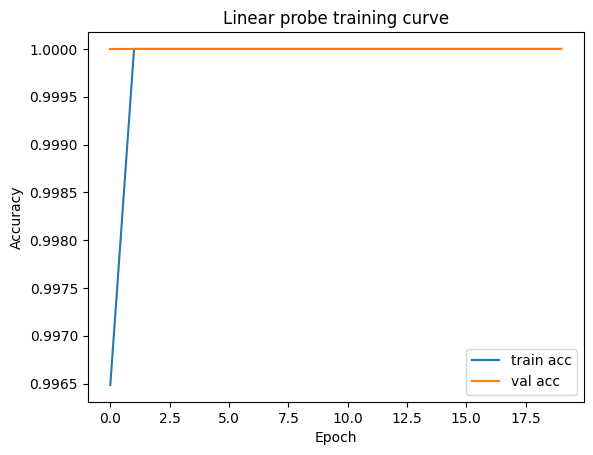

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Linear probe training curve")
plt.legend()
plt.show()

In [ ]:
linear_probe.save('/content/drive/MyDrive/downstream_model.keras')

In [ ]:
from tensorflow import keras

loaded_model = keras.models.load_model('/content/drive/MyDrive/downstream_model.keras')

In [ ]:
import os

os.listdir("/content/imagesoasis/Data")

['Moderate Dementia', 'Mild Dementia', 'Very mild Dementia', 'Non Demented']